<a href="https://colab.research.google.com/github/LordLean/Tracking-Sources-Of-Online-Disinformation/blob/main/fyp_march.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Imports

In [1]:
import os
import tweepy as tw
import pandas as pd

import tqdm

# Download nltk dependencies. 
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Install keyword extractor package.
os.system("pip install rake-nltk")
from rake_nltk import Rake
# Initialize raker.
RAKER = Rake()

# Top-level-domain extractor package.
os.system("pip install tldextract")
from tldextract import extract

# Download data collection.py
os.system("gdown --id 1w3Aa8j3bMj6ax9M_gTG1oYq50EksJwvK")
from data_collection import get_feedly_data, get_feedparser_data

# Download visualization function. (plot.py)
os.system("gdown --id 1hpLQ7dMDTsyTtUZnPJF1SVhe6xG-4s_W")
from plot import plot_full_vs_keyword
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Twitter API keys + Authentication

In [2]:
# Twitter Keys
consumer_key= 
consumer_secret= 
access_token= 
access_token_secret= 

In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

## Standalone functions.


In [121]:
def extract_coordinates(row):
  '''
  Extracts coordinates from tweet if not null.
  '''
  if row['Tweet Coordinates']:
      return row['Tweet Coordinates']['coordinates']
  else:
      return None


def extract_place(row):
  '''
  Extracts place from tweet if not null, in the form of state, city, country.
  '''
  if row['Place Info']:
      return row['Place Info'].full_name
  else:
      return None


def get_untruncated_tweet(id):
  '''
  Look up function which returns the untruncated tweet if not a retweet. 
  '''
  status = api.get_status(id, tweet_mode="extended")
  try:
      return status.retweeted_status.full_text
  except AttributeError:  # Not a Retweet
      return status.full_text


def convert_urls(links):
  """
  Pull extended url str from str(dictionary) objects.
  """
  if links:
    if links[0] == "{":
      links = eval(links)
      links = links["expanded_url"]
  return links

def convert_datetime(date):
  """
  Convert datetime to date (YYYY-MM-DD)
  """
  if not date:
    return
  year = str(date.year)
  month = str(date.month)
  day = str(date.day)
  new_format = "-"
  return new_format.join([year,month,day]) 


def analyze_dataframe(df_):
  # Original User handle value counts.
  df_handles = df_[["Orig User Handle", "Orig User Location"]].value_counts()
  df_handles = pd.DataFrame(df_handles)
  display(df_handles)

  # Url value counts.
  df_url = df_["Tweet Links"].value_counts(normalize=True)
  df_url = pd.DataFrame(df_url)
  display(df_url)
  
  # Date value counts.
  df_date = df_["RT Datetime"].apply(lambda date: convert_datetime(date)).value_counts(normalize=True)
  df_date = pd.DataFrame(df_date)
  display(df_date)

  # Create dataframe for original user handle, their location, the reported RTing user location.
  location_df_ = pd.DataFrame(df_[["Orig User Handle", "Orig User Location", "RT User Location"]].value_counts())
  location_df_.sort_values(["Orig User Handle","RT User Location"], ascending=True)
  display(location_df_)


def get_retweeters(id):
  '''
  Param id (int): Id of a twitter status object.
  Returns the count of retweers for that tweet + sample of retweeters for a particular tweet.
  '''
  # Get retweet count from twitter status object.
  count_retweet = api.get_status(id, tweet_mode="extended").retweet_count

  # Get up to 100 users who retweeted above status:
  # Limitation - won't be able to get the older retweets if the tweet was retweeted more than 100 times before starting tracking.
  sample_retweeters = [api.get_user(user) for user in api.retweeters(id, tweet_mode="extended")]
  return count_retweet, sample_retweeters


def sentence_preprocessing(sentence, custom_stopwords=[]):
  
  # Tokenize sentence.
  tokenized_sentence = word_tokenize(sentence)

  # Set stopwords.
  stop_words = set(stopwords.words("english"))
  stop_words = stop_words.union(custom_stopwords)
  
  # Remove stopwords and set to lowercase.
  tokenized_sentence = [word.lower() for word in tokenized_sentence if word not in stop_words or word.isnumeric()]

  return tokenized_sentence


def url_parse(url):
  try:
    tsd, td, tsu = extract(url)
    return td + "." + tsu
  except TypeError:
    pass # Not all tweets have a url object.


def keyword_extraction(text, raker=RAKER):
  raker.extract_keywords_from_text(text)
  return raker.get_ranked_phrases()

## Custom Stopwords

In [5]:
custom_stopwords_words = ["no", "did", "does", "is", "should", "were", "would", "who", "what", "why", "politifact"]
custom_stopwords_punct = [".", ",", "'", "!", "?", "-", "’", "‘", ":", "“"]
custom_stopwords = custom_stopwords_punct + custom_stopwords_words

## Get Headlines

In [120]:
# Get news items.
num = 10
news = get_feedly_data(num)

## Set Twitter Search Parameters

In [11]:
query = "https://redstate.com/nick-arama/2021/02/03/321029-n321029"
query = "refugees filter:links"
query = "url:redstate.com/nick-arama/2021/02/03/321029-n321029"
query = "Redstate AOC Capitol"

# Cursor arguments.
cursor_args = {
    "query" : query,
    "username" : "",
    "lang" : "en",
    "coordinates" : "40.7128, 74.0060, 200mi",
    "date_since" : "2020-11-16", # YYYY-MM-DD
    "result_type" : "mixed", # mixed, recent, popular
    "max_tweets" : 300
}

max_tweets = cursor_args["max_tweets"]

# Twitter Search

## Twitter Search Function

In [13]:
def twitter_search(query_, max_tweets=cursor_args["max_tweets"]):
  # API Search - https://docs.tweepy.org/en/latest/api.html - ctrl+f "Search Methods"
  tweets = tw.Cursor(api.search,
                    q = query_,
                    result_type = cursor_args["result_type"],
                    # lang = cursor_args["lang"],
                    tweet_mode = "extended",
                    include_entities = True
                    ).items(max_tweets)

  # Pull info from tweets iterable.
  final_list = []
  for tweet in tweets:
    if hasattr(tweet, "retweeted_status") and tweet.entities["urls"]:
      tweet_info = [tweet.full_text, str(tweet.entities["urls"][0]), tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.user.location, tweet.lang, tweet.source, tweet.retweeted_status.created_at, tweet.retweeted_status.id_str, tweet.retweeted_status.user.screen_name, tweet.retweeted_status.user.location, tweet.retweeted_status.lang, tweet.retweeted_status.source]
      final_list.append(tweet_info)
    elif not hasattr(tweet, "retweeted_status") and tweet.entities["urls"]:
      tweet_info = [tweet.full_text, tweet.entities["urls"][0]["expanded_url"], tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.user.location, tweet.lang, tweet.source, None, None, None, None, None, None]
      final_list.append(tweet_info)
    elif hasattr(tweet, "retweeted_status") and not tweet.entities["urls"]:
      tweet_info = [tweet.full_text, None, tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.user.location, tweet.lang, tweet.source, tweet.retweeted_status.created_at, tweet.retweeted_status.id_str, tweet.retweeted_status.user.screen_name, tweet.retweeted_status.user.location, tweet.retweeted_status.lang, tweet.retweeted_status.source]
      final_list.append(tweet_info)
    elif not hasattr(tweet, "retweeted_status") and not tweet.entities["urls"]:
      tweet_info = [tweet.full_text, None, tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.user.location, tweet.lang, tweet.source, None, None, None, None, None, None]
      final_list.append(tweet_info)      

  # Create dataframe for specified above information.
  df = pd.DataFrame(final_list,columns=["Full Text", "Tweet Links", "RT Datetime", "RT Id", "RT User Handle", "RT User Location", "RT User Language", "RT User Source", "Orig Datetime", "Orig Tweet Id", "Orig User Handle", "Orig User Location", "Orig User Language", "Orig User Source"])
  # Pull all extended urls.
  df["Tweet Links"] = df["Tweet Links"].apply(lambda links: convert_urls(links))

  return df

## Disinformation Event Search Function

In [147]:
def event_search(news_item, initial_tweet_count=1000, url_specific_tweet_count=200):
  """
  For a given event/news item: search for query then search all urls returned from initial query.
  Store all search results in the passed news_item dictionary in newly created keys. 
  Keys:
    "keywords" : Ranked sets of keywords. 
    "query" : Keywords formatted for Twitter's search API.
    "dataFrame" : Dataframe housing initial search results (using keyword query).
    "top_level_domains" : For housing url specific search queries, grouped by top-level domains.
  Function augments passed new_item dict with new keys and values.
  """
  event_dict = news_item
  # Pull article headline.
  headline = event_dict["title"]
  # Extract keywords from article.
  event_dict["keywords"] = keyword_extraction(headline)
  # Build query from keywords. (SIMPLE)
  event_dict["query"] = " ".join(event_dict["keywords"])
  # Create inner dictionary to store url specific information.
  event_dict["top_level_domains"] = {}

  # Run twitter search, store resultant dataframe in dictionary.
  event_dict["dataFrame"] = twitter_search(event_dict["query"], initial_tweet_count)
  # Get all unique links used in tweets collection.
  urls = event_dict["dataFrame"]["Tweet Links"].unique()
  for url in urls:
    # Get top-level-domain per url.
    tld = url_parse(url)
    # Use full url as search query argument.
    url_queried_df = twitter_search("url:{}".format(url), max_tweets)
    # If unseen top level domain, create inner dictionary.
    if tld not in event_dict["top_level_domains"].keys():
      event_dict["top_level_domains"][tld] = {url : url_queried_df}
    # If previously seen top level domain, add to inner dictionary.
    else:
      event_dict["top_level_domains"].get(tld)[url] = url_queried_df

## Run Search

In [154]:
for news_item in news:
  event_search(news_item=news_item)

In [155]:
news[8].keys()

dict_keys(['title', 'date', 'link', 'source', 'keywords', 'query', 'topLevelDomains', 'dataFrame'])

### Current Dev Set

In [ ]:
# fake_list = [("Hillary Clinton", "navy seals arrest hillary clinton")]
# for headline, query in fake_list:
# %%time

initial_tweet_count = 1000
url_specific_tweet_count = 200

events_list = []
for headline, query in zip(headlines_full, headlines_keywords):
  # Create outmost dictionary to hold core infomation.
  event_dict = {"Headline":headline, "Query":query, "TopLevelDomains":{}}
  # Run twitter search, store resultant dataframe in dictionary.
  event_dict["DataFrame"] = twitter_search(query, initial_tweet_count)
  # Get all unique links used in tweets collection.
  urls = event_dict["DataFrame"]["Tweet Links"].unique()

  for url in urls:
    # Get top-level-domain per url.
    tld = url_parse(url)
    # Use full url as search query argument.
    url_queried_df = twitter_search("url:{}".format(url), max_tweets)
    # If unseen top level domain, create inner dictionary.
    if tld not in event_dict["TopLevelDomains"].keys():
      event_dict["TopLevelDomains"][tld] = {url : url_queried_df}
    # If previously seen top level domain, add to inner dictionary.
    else:
      event_dict["TopLevelDomains"].get(tld)[url] = url_queried_df
  # Append complete event-level dictionary to list.
  events_list.append(event_dict)

In [93]:
index = 5
print(events_list[index]["Headline"])
print(events_list[index]["Query"])
list(events_list[index]["TopLevelDomains"].keys())

Was Biden Filmed Talking to Press in Front of a Green Screen?
biden filmed talking green screen press front


['Snopes.com', 'snopes.com', 'dlvr.it']

In [109]:
events_list[index]["DataFrame"]

,Full Text,Tweet Links,RT Datetime,RT Id,RT User Handle,RT User Location,RT User Language,RT User Source,Orig Datetime,Orig Tweet Id,Orig User Handle,Orig User Location,Orig User Language,Orig User Source
0,Was Biden Filmed Talking to Press in Front of ...,http://Snopes.com,2021-03-19 09:55:15,1372849138962927619,MaryStone011,,en,Twitter for iPhone,NaT,None,None,None,None,None
1,Was Biden Filmed Talking to Press in Front of ...,http://Snopes.com,2021-03-19 09:27:05,1372842048236163072,jptrib1,,en,Twitter for iPhone,NaT,None,None,None,None,None
2,Was Biden Filmed Talking to Press in Front of ...,https://www.snopes.com/fact-check/biden-green-...,2021-03-19 01:12:36,1372717609817235456,HOTROCKTV,MIAMI /G\ HAWAII,en,Twitter Web App,NaT,None,None,None,None,None
3,For the nut job RW conspiracy theorists out th...,http://Snopes.com,2021-03-18 23:55:10,1372698121273274369,BreezyLovinInWV,NC🌊 by way of WV⛰ (USA),en,Twitter for iPhone,NaT,None,None,None,None,None
4,RT @Charger0843Rion: Was Biden Filmed Talking ...,https://www.snopes.com/fact-check/biden-green-...,2021-03-18 23:31:16,1372692106318204928,equi_noctis,,en,Twitter for iPad,2021-03-18 21:50:27,1372666737179627528,Charger0843Rion,"Virginia, USA",en,Twitter Web App
5,Was Biden Filmed Talking to Press in Front of ...,https://www.snopes.com/fact-check/biden-green-...,2021-03-18 22:56:48,1372683434909298693,caroloptera,Canada,en,Twitter Web App,NaT,None,None,None,None,None
6,Was Biden Filmed Talking to Press in Front of ...,https://www.snopes.com/fact-check/biden-green-...,2021-03-18 21:50:27,1372666737179627528,Charger0843Rion,"Virginia, USA",en,Twitter Web App,NaT,None,None,None,None,None
7,Was Biden Filmed Talking to Press in Front of ...,https://www.snopes.com/fact-check/biden-green-...,2021-03-18 20:21:55,1372644455182958595,intranautt,"Raleigh, NC, Chapel Hill,NC",en,Twitter Web App,NaT,None,None,None,None,None
8,RT @fwtoney: Was Biden Filmed Talking to Press...,https://www.snopes.com/fact-check/biden-green-...,2021-03-18 17:27:15,1372600501083193344,UncleTummyTX,Lexington South Carolina,en,Twitter Web App,2021-03-18 17:09:41,1372596081016573953,fwtoney,Fort Worth,en,Twitter Web App
9,Was Biden Filmed Talking to Press in Front of ...,http://dlvr.it/RvvW9K,2021-03-18 17:26:04,1372600201299456003,FightTheLie,London,en,dlvr.it,NaT,None,None,None,None,None


In [96]:
test = twitter_search("biden green screen")

In [ ]:
[text for text in list(test["Tweet Links"].unique()) if isinstance(text, str) and "twitter" in text]

In [104]:
[text for text in list(test["Tweet Links"].unique()) if isinstance(text, str) and "twitter" in text]

['https://twitter.com/thehill/status/1371898779922804737',
 'https://twitter.com/JohnMappin/status/1372170188821569536',
 'https://twitter.com/RubinReport/status/1372037591902523394',
 'https://twitter.com/20PercentDash/status/1372279583450488834',
 'https://twitter.com/ak4wa/status/1372044947235348480',
 'https://twitter.com/vinarmani/status/1372288796293615617',
 'https://twitter.com/remasculate/status/1372238051888402432',
 'https://twitter.com/flossyflange/status/1372185396675813376',
 'https://twitter.com/MichealMartinTD/status/1372244339146031108',
 'https://twitter.com/JackPosobiec/status/1372038951461076992']

In [94]:
events_list[index]["DataFrame"]

,Full Text,Tweet Links,RT Datetime,RT Id,RT User Handle,RT User Location,RT User Language,RT User Source,Orig Datetime,Orig Tweet Id,Orig User Handle,Orig User Location,Orig User Language,Orig User Source
0,Was Biden Filmed Talking to Press in Front of ...,http://Snopes.com,2021-03-19 09:55:15,1372849138962927619,MaryStone011,,en,Twitter for iPhone,NaT,None,None,None,None,None
1,Was Biden Filmed Talking to Press in Front of ...,http://Snopes.com,2021-03-19 09:27:05,1372842048236163072,jptrib1,,en,Twitter for iPhone,NaT,None,None,None,None,None
2,Was Biden Filmed Talking to Press in Front of ...,https://www.snopes.com/fact-check/biden-green-...,2021-03-19 01:12:36,1372717609817235456,HOTROCKTV,MIAMI /G\ HAWAII,en,Twitter Web App,NaT,None,None,None,None,None
3,For the nut job RW conspiracy theorists out th...,http://Snopes.com,2021-03-18 23:55:10,1372698121273274369,BreezyLovinInWV,NC🌊 by way of WV⛰ (USA),en,Twitter for iPhone,NaT,None,None,None,None,None
4,RT @Charger0843Rion: Was Biden Filmed Talking ...,https://www.snopes.com/fact-check/biden-green-...,2021-03-18 23:31:16,1372692106318204928,equi_noctis,,en,Twitter for iPad,2021-03-18 21:50:27,1372666737179627528,Charger0843Rion,"Virginia, USA",en,Twitter Web App
5,Was Biden Filmed Talking to Press in Front of ...,https://www.snopes.com/fact-check/biden-green-...,2021-03-18 22:56:48,1372683434909298693,caroloptera,Canada,en,Twitter Web App,NaT,None,None,None,None,None
6,Was Biden Filmed Talking to Press in Front of ...,https://www.snopes.com/fact-check/biden-green-...,2021-03-18 21:50:27,1372666737179627528,Charger0843Rion,"Virginia, USA",en,Twitter Web App,NaT,None,None,None,None,None
7,Was Biden Filmed Talking to Press in Front of ...,https://www.snopes.com/fact-check/biden-green-...,2021-03-18 20:21:55,1372644455182958595,intranautt,"Raleigh, NC, Chapel Hill,NC",en,Twitter Web App,NaT,None,None,None,None,None
8,RT @fwtoney: Was Biden Filmed Talking to Press...,https://www.snopes.com/fact-check/biden-green-...,2021-03-18 17:27:15,1372600501083193344,UncleTummyTX,Lexington South Carolina,en,Twitter Web App,2021-03-18 17:09:41,1372596081016573953,fwtoney,Fort Worth,en,Twitter Web App
9,Was Biden Filmed Talking to Press in Front of ...,http://dlvr.it/RvvW9K,2021-03-18 17:26:04,1372600201299456003,FightTheLie,London,en,dlvr.it,NaT,None,None,None,None,None


In [92]:
events_list[index]["TopLevelDomains"]["dlvr.it"]["http://dlvr.it/RvvW9K"]

,Full Text,Tweet Links,RT Datetime,RT Id,RT User Handle,RT User Location,RT User Language,RT User Source,Orig Datetime,Orig Tweet Id,Orig User Handle,Orig User Location,Orig User Language,Orig User Source
0,Was Biden Filmed Talking to Press in Front of ...,http://dlvr.it/RvvW9K,2021-03-18 17:26:04,1372600201299456003,FightTheLie,London,en,dlvr.it,NaT,None,None,None,None,None
1,RT @sofokleous10: Τσαβούσογλου στην ΕΕ: Αν μας...,http://dlvr.it/RvVW9k,2021-03-13 15:07:06,1370753292146413573,sofokleous10,Athens,el,dlvr.it,2021-03-12 15:05:33,1370390511350026241,sofokleous10,Athens,el,dlvr.it
2,RT @sofokleous10: Τσαβούσογλου στην ΕΕ: Αν μας...,http://dlvr.it/RvVW9k,2021-03-12 15:06:04,1370390643789336581,thetimesgr,,el,dlvr.it,2021-03-12 15:05:33,1370390511350026241,sofokleous10,Athens,el,dlvr.it
3,Τσαβούσογλου στην ΕΕ: Αν μας επιβληθούν κυρώσε...,http://dlvr.it/RvVW9k,2021-03-12 15:05:33,1370390511350026241,sofokleous10,Athens,el,dlvr.it,NaT,None,None,None,None,None


### Legacy Dev Set

In [ ]:
collection_keywords = [twitter_search(query, max_tweets) for query in tqdm.tqdm(headlines_keywords)]

In [ ]:
collection_full = [twitter_search(query, max_tweets) for query in tqdm.tqdm(headlines_full)]

In [ ]:
labels = [headline for headline in headlines_keywords]
full_search = [len(item) for item in collection_full]
keyword_search = [len(item) for item in collection_keywords]

plot_full_vs_keyword(labels, full_search, keyword_search)

In [ ]:
difference = 10

for headline1, headline2, full_count, keyword_count in zip(headlines_full, headlines_keywords, full_search, keyword_search):
  if full_count - difference <= keyword_count <= full_count + difference:
    print("No Change: {} vs. {}".format(full_count, keyword_count))
    print(headline1, "\n{}".format(headline2))
    print("\n")
  else:
    print("Change: {} vs. {}".format(full_count, keyword_count))
    print(headline1, "\n{}".format(headline2))
    print("\n")

In [ ]:
# Get more complete information for initially maxed out queries. Increase max_tweets to 1000.
collection_keywords_large = [{"query" : query, "dataframe" : twitter_search(query, 1000)} for df, query in tqdm.tqdm(zip(collection_keywords, headlines_keywords)) if len(df) == max_tweets]

30it [00:09,  3.28it/s]


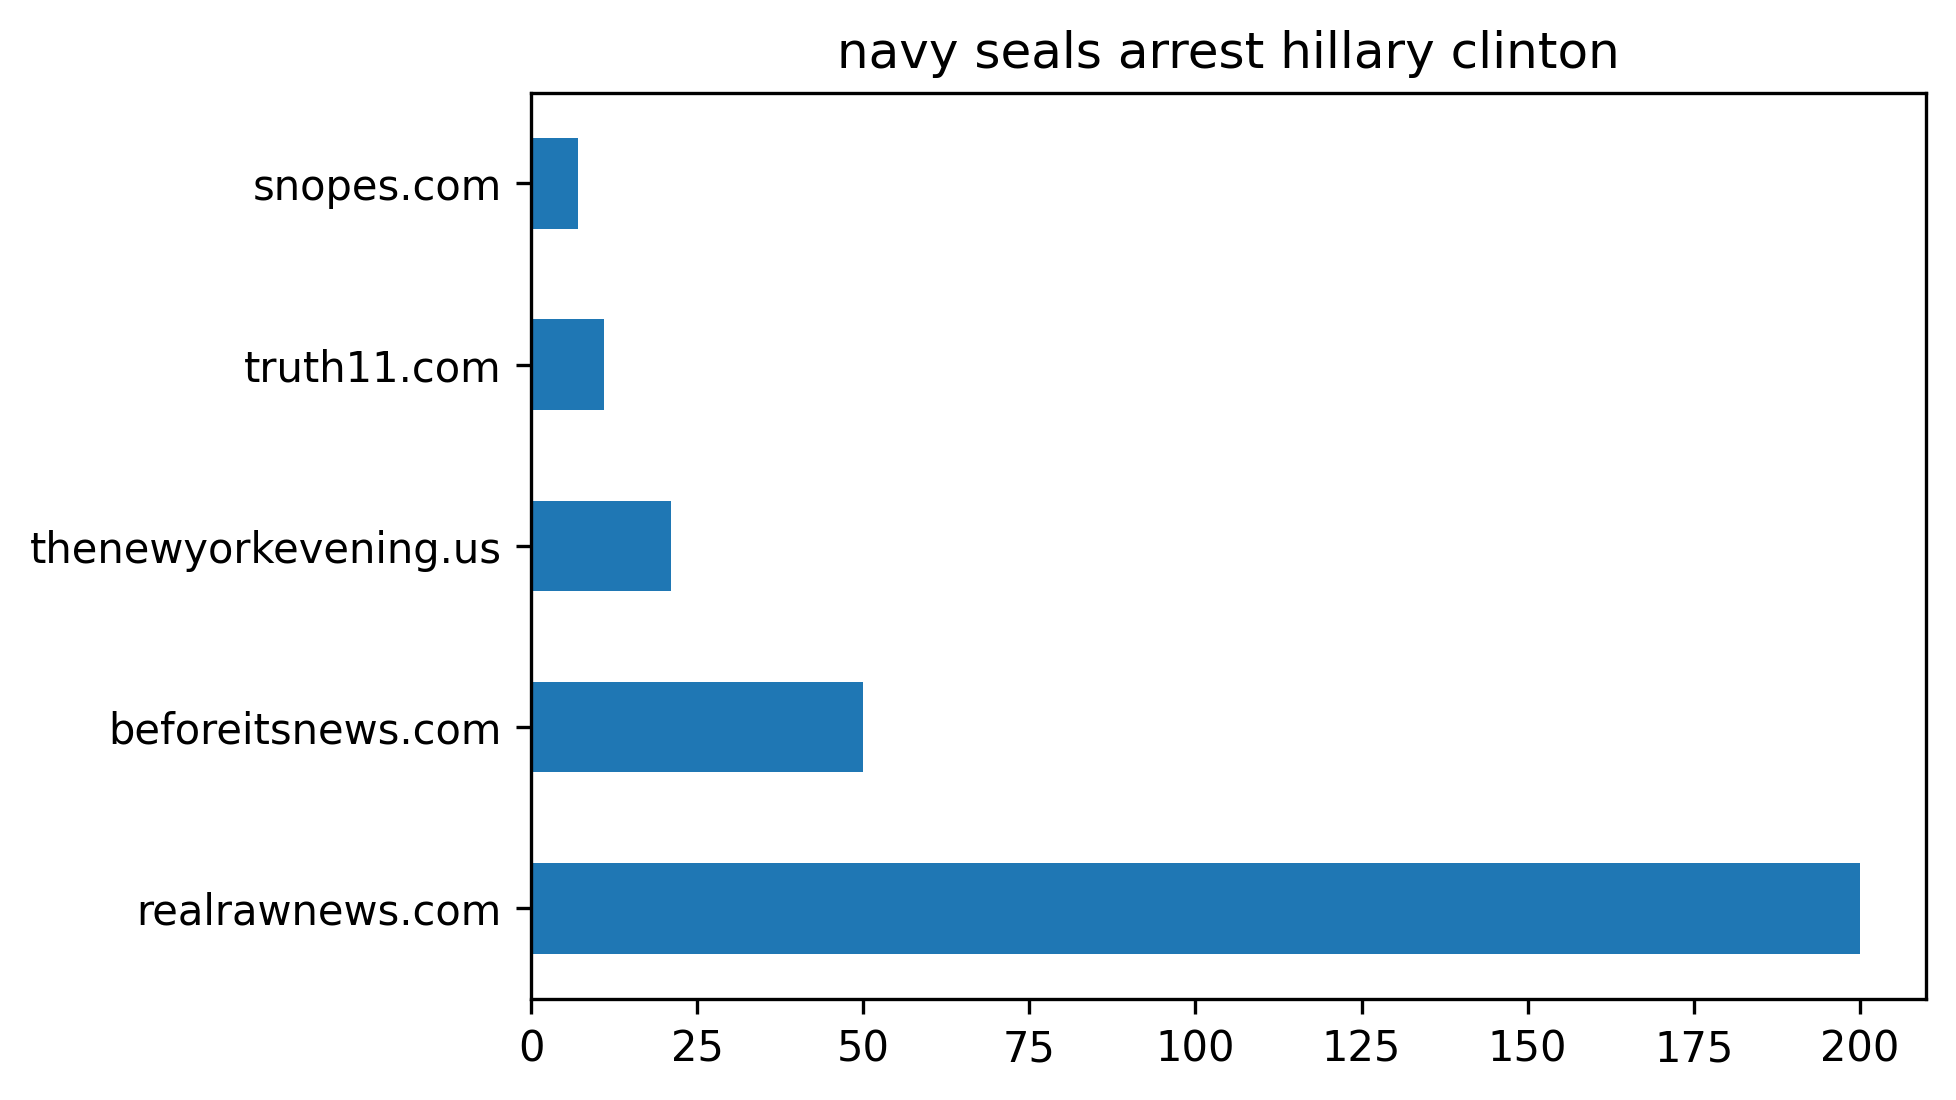

In [ ]:
index = 0
t = collection_keywords_large[index]["query"]
collection_keywords_large[index]["dataframe"]["Tweet Links"].apply(lambda x: url_parse(x)).value_counts()[:5].plot(kind="barh",title=t)

# Old

In [ ]:
if cursor_args["username"]:
  # User Timeline
  tweets = tw.Cursor(api.user_timeline,
                    id = cursor_args["username"], 
                    tweet_mode = "extended"
                    ).items(cursor_args["max_tweets"])
else:
  # API Search - https://docs.tweepy.org/en/latest/api.html - ctrl+f "Search Methods"
  tweets = tw.Cursor(api.search,
                    q = cursor_args["query"],
                    # geocode = cursor_args["coordinates"],
                    result_type = "recent", # mixed, recent, popular
                    lang = cursor_args["lang"],
                    include_entities = True,
                    tweet_mode = "extended"
                    ).items(cursor_args["max_tweets"])


# Pull info from tweets iterable.
final_list = []
for tweet in tweets:
  if hasattr(tweet, "retweeted_status") and tweet.entities["urls"]:
    tweet_info = [tweet.full_text, str(tweet.entities["urls"][0]), tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.user.location, tweet.lang, tweet.source, tweet.retweeted_status.created_at, tweet.retweeted_status.id_str, tweet.retweeted_status.user.screen_name, tweet.retweeted_status.user.location, tweet.retweeted_status.lang, tweet.retweeted_status.source]
    final_list.append(tweet_info)
  elif not hasattr(tweet, "retweeted_status") and tweet.entities["urls"]:
    tweet_info = [tweet.full_text, tweet.entities["urls"][0]["expanded_url"], tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.user.location, tweet.lang, tweet.source, None, None, None, None, None, None]
    final_list.append(tweet_info)

    


# Create dataframe for specified above information.
df = pd.DataFrame(final_list,columns=["Full Text", "Tweet Links", "RT Datetime", "RT Id", "RT User Handle", "RT User Location", "RT User Language", "RT User Source", "Orig Datetime", "Orig Tweet Id", "Orig User Handle", "Orig User Location", "Orig User Language", "Orig User Source"])
# Pull all extended urls.
df["Tweet Links"] = df["Tweet Links"].apply(lambda links: convert_urls(links))

In [ ]:
df

,Full Text,Tweet Links,RT Datetime,RT Id,RT User Handle,RT User Location,RT User Language,RT User Source,Orig Datetime,Orig Tweet Id,Orig User Handle,Orig User Location,Orig User Language,Orig User Source
0,A screenshot purports to show a 2016 tweet fro...,http://ow.ly/HWNM30rxDgW,2021-02-19 23:46:09,1362911381465497600,factcheckdotorg,Philadelphia,en,Hootsuite Inc.,NaT,None,None,None,None,None
1,Viral Posts Attribute Fake Tweet to Cruz https...,https://bit.ly/2NK6m9g,2021-02-20 22:43:32,1363258012194856962,FactsRising,,en,dlvr.it,NaT,None,None,None,None,None
2,Viral Posts Attribute Fake Tweet to Cruz https...,http://a.msn.com/01/en-us/BB1dQnpc?ocid=st,2021-02-20 21:34:20,1363240594877784064,SSGEricB,Las Vegas,en,Twitter Web App,NaT,None,None,None,None,None
3,@Arterix6 @SkyAJohnson @rekcut__ https://t.co/...,https://www.factcheck.org/2021/02/viral-posts-...,2021-02-20 17:02:09,1363172098470912002,XYM800,,en,Twitter for iPhone,NaT,None,None,None,None,None
4,Viral Posts Attribute Fake Tweet to Cruz\n ht...,https://www.factcheck.org/2021/02/viral-posts-...,2021-02-20 16:17:51,1363160949545336833,sftwengnr,,en,Twitter for iPad,NaT,None,None,None,None,None
5,RT @firefly909: Viral Posts Attribute Fake Twe...,http://a.msn.com/01/en-us/BB1dQnpc?ocid=st,2021-02-20 16:00:44,1363156642884243459,pearlfromca,"California, USA",en,Twitter for iPhone,2021-02-20 14:22:59,1363132041168965632,firefly909,United States,en,Twitter Web App
6,RT @firefly909: Viral Posts Attribute Fake Twe...,http://a.msn.com/01/en-us/BB1dQnpc?ocid=st,2021-02-20 14:55:08,1363140132321206274,zen4ever2us,"California, USA",en,Twitter for iPhone,2021-02-20 14:22:59,1363132041168965632,firefly909,United States,en,Twitter Web App
7,Viral Posts Attribute Fake Tweet to Cruz https...,http://a.msn.com/01/en-us/BB1dQnpc?ocid=st,2021-02-20 14:22:59,1363132041168965632,firefly909,United States,en,Twitter Web App,NaT,None,None,None,None,None
8,"@rezaaslan Funny, but he didn't Tweet that. Th...",https://www.factcheck.org/2021/02/viral-posts-...,2021-02-20 13:34:18,1363119791238766592,DrMikeSmithPR,Philadelphia area,en,Twitter for Android,NaT,None,None,None,None,None
9,@rezaaslan Ted Cruz did not say it. Sources: ...,https://www.cnn.com/2021/02/19/politics/fact-c...,2021-02-20 03:21:46,1362965643432235010,mustard_seeds,Figment of your imagination,en,Twitter for iPad,NaT,None,None,None,None,None


In [ ]:
df["Full Text"][0]

'Anyone who likes this bitch needs their head examined immediately \n\nhttps://t.co/2GT6R3PvjU'

In [ ]:
analyze_dataframe(df)

,,0
Orig User Handle,Orig User Location,
dodo,"New York, NY",28
apofissx,,10
DiamondDivasPSK,Inside Your Filthy Mind,6
SaraUnderwood,Oregon,3
catsnkittys,,3
_lilihwan,"Buenos Aires, Argentina",3
KevinScampi,The World of K S L,2
cobbkitties,"Marietta, GA",2
GenshinImpact,,1


,Tweet Links
https://www.patreon.com/apofiss,0.344828
http://bit.ly/2E0ra3N,0.206897
https://open.spotify.com/show/66MmjNj2yWKSgNUORLJIek?nd=1,0.206897
https://www.modelhub.com/video/ph5f0f7391d5189,0.034483
https://instagr.am/p/CLW2VitHQYW/,0.034483
https://pooo.st/bV8OW,0.034483
https://buff.ly/376oukF,0.034483
https://docs.google.com/forms/d/e/1FAIpQLSe0lNY7fvkGXTMA8b7NDsrD7Q7-9Mcr8dbVNEqeZi0rOFP3XA/viewform?usp=sf_link,0.034483
https://aldf.org/article/urge-the-usda-to-investigate-adorable-stars-and-protect-kittens,0.034483
http://Afterlifeblog.com,0.034483


,RT Datetime
2021-2-14,0.87
2021-2-16,0.12
2021-2-15,0.01


0
Orig User Handle Orig User Location      RT User Location              
dodo             New York, NY                                        12
DiamondDivasPSK  Inside Your Filthy Mind                              4
apofissx                                                              3
catsnkittys                                                           2
_lilihwan        Buenos Aires, Argentina                              2
...                                                                  ..
damianicus       Los Angeles, CA                                      1
cobbkitties      Marietta, GA            Denver, CO                   1
                                         *Some Tweets Are Graphic*    1
catsnkittys                              Reston, Va                   1
Aawwwww_         Cologne, Germany        Norfolk, United kingdom      1

[61 rows x 1 columns]

# Redundant

In [ ]:
# Old unnecessary headline / keyword builder.

# # Create full headline list.
# headlines_full = [item["title"] for item in news]

# # Create keyword headline list.
# headlines_keywords = [" ".join(item["keywords"]) for item in news]
# headlines_keywords = [" ".join(sentence_preprocessing(headline, custom_stopwords_punct + custom_stopwords_words)) for headline in headlines_keywords]

# # Examine a selection of headlines.
# # for h1, h2, in zip(headlines_full[:5], headlines_keywords[:5]):
# #   print(h1,"\n{}".format(h2),"\n\n")

In [ ]:
# # Collect tweets
# tweets = tw.Cursor(api.search,
#                        q=search_words,
#                        lang="en"
#                        ).items(10000)

# # Collect a list of tweets
# all_tweets = [tweet.user for tweet in tweets]

In [ ]:
# from geopy.geocoders import Nominatim
# import gmplot

# geolocator = Nominatim()

# coordinates = {'latitude': [], 'longitude': []}
# for count, user_loc in enumerate(tweets.location):
#     try:
#         location = geolocator.geocode(user_loc)
        
#         # If coordinates are found for location
#         if location:
#             coordinates['latitude'].append(location.latitude)
#             coordinates['longitude'].append(location.longitude)
            
#     # If too many connection requests
#     except:
#         pass

In [ ]:
# # Old
# if cursor_args["username"]:
#   # User Timeline
#   tweets = tw.Cursor(api.user_timeline,
#                     id = cursor_args["username"], 
#                     tweet_mode = 'extended'
#                     ).items(cursor_args["max_tweets"])
# else:
#   # API Search - https://docs.tweepy.org/en/latest/api.html - ctrl+f "Search Methods"
#   tweets = tw.Cursor(api.search,
#                     q = cursor_args["query"],
#                     # geocode = cursor_args["coordinates"],
#                     result_type = "mixed", # mixed, recent, popular
#                     lang = cursor_args["lang"],
#                     tweet_mode = 'extended'
#                     ).items(cursor_args["max_tweets"])

# # tweets2 = deepcopy(tweets)
# # for tweet in tweets2:
# #   # print(tweet.retweeted_status)
# #   pass

# # Pulling information from tweets iterable object
# # Add or remove tweet information you want in the below list comprehension
# tweets_list = [[tweet.full_text, tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.retweeted_status.user.Name, tweet.user.location, tweet.coordinates, tweet.place, tweet.retweet_count, tweet.favorite_count, tweet.lang, tweet.source, tweet.in_reply_to_status_id_str, tweet.in_reply_to_user_id_str, tweet.is_quote_status] for tweet in tweets if hasattr(tweet,"retweeted_status")]
 
# # Creation of dataframe from tweets_list
# # Add or remove columns as you remove tweet information
# tweets_df = pd.DataFrame(tweets_list,columns=['Tweet Text', 'Tweet Datetime', 'Tweet Id', 'Twitter @ Name', "Retweeted Tweet", "Location", 'Tweet Coordinates', 'Place Info', 'Retweets', 'Favorites', 'Language', 'Source', 'Replied Tweet Id', 'Replied Tweet User Id Str', 'Quote Status Bool'])
 
# # Checks if there are coordinates attached to tweets, if so extracts them
# tweets_df['Tweet Coordinates'] = tweets_df.apply(extract_coordinates,axis=1)
 
# # Checks if there is place information available, if so extracts them
# tweets_df['Place Info'] = tweets_df.apply(extract_place,axis=1)

In [ ]:
# if cursor_args["username"]:
#   # User Timeline
#   tweets = tw.Cursor(api.user_timeline,
#                     id = cursor_args["username"], 
#                     tweet_mode = "extended"
#                     ).items(cursor_args["max_tweets"])
# else:
#   # API Search - https://docs.tweepy.org/en/latest/api.html - ctrl+f "Search Methods"
#   tweets = tw.Cursor(api.search,
#                     q = cursor_args["query"],
#                     # geocode = cursor_args["coordinates"],
#                     result_type = "mixed", # mixed, recent, popular
#                     lang = cursor_args["lang"],
#                     include_entities = True,
#                     tweet_mode = "extended"
#                     ).items(cursor_args["max_tweets"])


# # Pull info from tweets iterable.
# tweets_list = [[tweet.full_text, tweet.entities["urls"][0], tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.user.location, tweet.lang, tweet.source, tweet.retweeted_status.user.screen_name, tweet.retweeted_status.created_at, tweet.retweeted_status.id_str, tweet.retweeted_status.user.screen_name, tweet.retweeted_status.user.location, tweet.retweeted_status.lang, tweet.retweeted_status.source] for tweet in tweets if hasattr(tweet,"retweeted_status") and tweet.entities["urls"]]
 
# # Create dataframe for specified above information.
# df = pd.DataFrame(tweets_list,columns=["RT Full Text", "Tweet Links", "RT Datetime", "RT Id", "RT User Handle", "RT User Location", "RT User Language", "RT User Source", "Orig User Handle", "Orig Datetime", "Orig Tweet Id", "Orig User Handle", "Orig User Location", "Orig User Language", "Orig User Source"])

In [ ]:
# from google.colab import files
# import gmplot
# from geopy.geocoders import Nominatim

# locations = list(df["RT User Location"].unique())

# geolocator = Nominatim(user_agent="http")

# # Go through all tweets and add locations to 'coordinates' dictionary
# coordinates = {'latitude': [], 'longitude': []}
# for count, user_loc in enumerate(locations):
#     try:
#         location = geolocator.geocode(user_loc)
        
#         # If coordinates are found for location
#         if location:
#             coordinates['latitude'].append(location.latitude)
#             coordinates['longitude'].append(location.longitude)
            
#     # If too many connection requests
#     except:
#         pass
    
# # Instantiate and center a GoogleMapPlotter object to show our map
# gmap = gmplot.GoogleMapPlotter(30, 0, 3)

# # Insert points on the map passing a list of latitudes and longitudes
# gmap.heatmap(coordinates['latitude'], coordinates['longitude'], radius=20)

# # Save the map to html file
# gmap.draw("python_heatmap.html")

# # Download html
# files.download("python_heatmap.html")

In [ ]:
# # 16/02/21
# if cursor_args["username"]:
#   # User Timeline
#   tweets = tw.Cursor(api.user_timeline,
#                     id = cursor_args["username"], 
#                     tweet_mode = "extended"
#                     ).items(cursor_args["max_tweets"])
# else:
#   # API Search - https://docs.tweepy.org/en/latest/api.html - ctrl+f "Search Methods"
#   tweets = tw.Cursor(api.search,
#                     q = cursor_args["query"],
#                     # geocode = cursor_args["coordinates"],
#                     result_type = "mixed", # mixed, recent, popular
#                     lang = cursor_args["lang"],
#                     include_entities = True,
#                     tweet_mode = "extended"
#                     ).items(cursor_args["max_tweets"])


# # Pull info from tweets iterable.
# final_list = []
# for tweet in tweets:
#   if hasattr(tweet, "retweeted_status") and tweet.entities["urls"]:
#     tweet_info = [tweet.full_text, str(tweet.entities["urls"][0]), tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.user.location, tweet.lang, tweet.source, tweet.retweeted_status.created_at, tweet.retweeted_status.id_str, tweet.retweeted_status.user.screen_name, tweet.retweeted_status.user.location, tweet.retweeted_status.lang, tweet.retweeted_status.source]
#     final_list.append(tweet_info)
#   elif not hasattr(tweet, "retweeted_status") and tweet.entities["urls"]:
#     tweet_info = [tweet.full_text, tweet.entities["urls"][0]["expanded_url"], tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.user.location, tweet.lang, tweet.source, None, None, None, None, None, None]
#     final_list.append(tweet_info)
#   # elif hasattr(tweet, "retweeted_status") and not tweet.entities["urls"]:
#   #   tweet_info = [tweet.full_text, None, tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.user.location, tweet.lang, tweet.source, tweet.retweeted_status.created_at, tweet.retweeted_status.id_str, tweet.retweeted_status.user.screen_name, tweet.retweeted_status.user.location, tweet.retweeted_status.lang, tweet.retweeted_status.source]
#   #   final_list.append(tweet_info)
#   # elif not hasattr(tweet, "retweeted_status") and not tweet.entities["urls"]:
#   #   tweet_info = [tweet.full_text, None, tweet.created_at, tweet.id_str, tweet.user.screen_name, tweet.user.location, tweet.lang, tweet.source, None, None, None, None, None, None]
#   #   final_list.append(tweet_info)
    


# # Create dataframe for specified above information.
# df = pd.DataFrame(final_list,columns=["Full Text", "Tweet Links", "RT Datetime", "RT Id", "RT User Handle", "RT User Location", "RT User Language", "RT User Source", "Orig Datetime", "Orig Tweet Id", "Orig User Handle", "Orig User Location", "Orig User Language", "Orig User Source"])
# # Pull all extended urls.
# df["Tweet Links"] = df["Tweet Links"].apply(lambda links: convert_urls(links))